## Initial numpyro installation

In [1]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 283 kB 5.3 MB/s 


## Needed imports


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

import time
from datetime import timedelta, date, datetime
from copy import deepcopy


# fix MCMCndom generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

## Read file with bitcoin prices in USD

In [3]:
df_price = pd.read_csv('/content/drive/MyDrive/model-based/BTC-USD.csv', parse_dates=True)

## See sample data in table

In [4]:
df_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [78]:
df_price = df_price.drop(columns = ["Open", "High", "Low", "Close", "Volume"])

## Visualize the BTC price in time

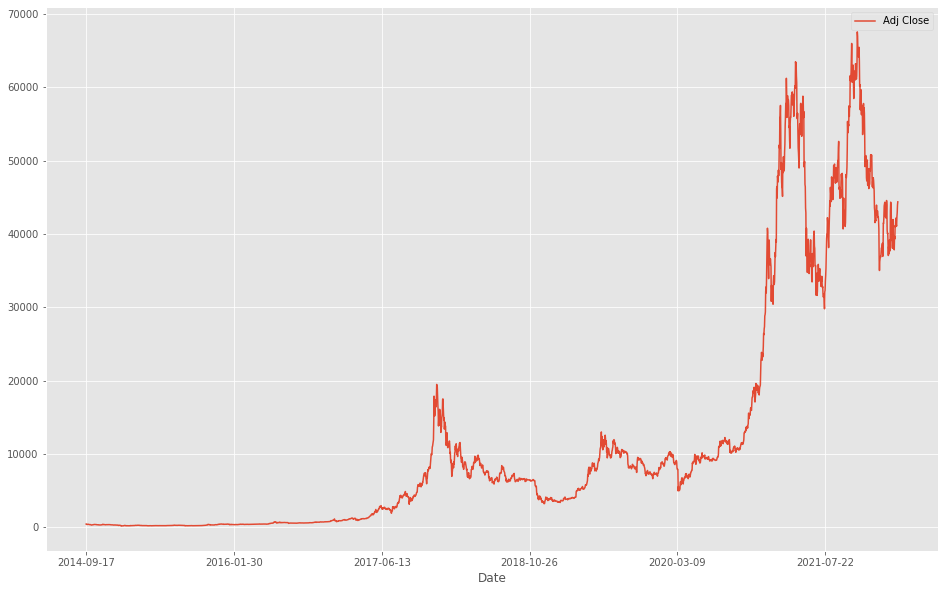

In [79]:
df_price.plot(x="Date", y="Adj Close")
plt.show()

## Load USD index data

In [81]:
df_usd = pd.read_csv('/content/drive/MyDrive/model-based/USD_historical_data.csv', parse_dates=True) 
print(df_usd.head(10))
# remove unnecessary columns
df_usd =df_usd.drop(columns=["Open", "High", "Low", "Vol.", "Change %"])
# print shape of both data frames
print(df_usd.shape)
print(df_price.shape)

           Date  Price   Open   High    Low Vol. Change %
0  Sep 17, 2014  84.34  84.10  84.78  83.94    -    0.32%
1  Sep 18, 2014  84.32  84.80  84.74  84.22    -   -0.02%
2  Sep 19, 2014  84.73  84.28  84.80  84.23    -    0.49%
3  Sep 22, 2014  84.75  84.78  84.86  84.52    -    0.02%
4  Sep 23, 2014  84.66  84.68  84.76  84.36    -   -0.11%
5  Sep 24, 2014  85.04  84.71  85.09  84.60    -    0.45%
6  Sep 25, 2014  85.19  85.10  85.48  85.05    -    0.18%
7  Sep 26, 2014  85.64  85.14  85.69  85.11    -    0.53%
8  Sep 29, 2014  85.59  85.62  85.80  85.46    -   -0.06%
9  Sep 30, 2014  85.94  85.61  86.22  85.49    -    0.41%
(1963, 2)
(2747, 2)


## As we see the shapes do not match, we notice that USD index data is missing entries for weekend days, we will fill this data with values from Friday.

In [82]:
N = df_usd.shape[0]
usd_list = df_usd.to_numpy() # change for numpy array

# add data for the weekend
usd_data =[]
for i in range(3, N, 5):
  if(i>=5):
    usd_data = np.vstack((usd_data, usd_list[i-5:i,:]))
  else: # first week
    usd_data = usd_list[0:i, :]
  # copy Friday data
  copy_friday =  deepcopy(usd_list[i-1,:])
  # change the day
  copy_friday[0] = datetime.strptime(copy_friday[0], "%b %d, %Y") + timedelta(days=1)
  # add data for Saturday
  usd_data = np.vstack((usd_data,copy_friday))
  # move one day
  copy_friday[0] = copy_friday[0] + timedelta(days=1)
  # add data for Sunday
  usd_data = np.vstack((usd_data,copy_friday))

# we are missing data for the last 5 dys
usd_data = np.vstack((usd_data,usd_list[-5:,:]))
# print length to check if it matches 
print(len(usd_data))

2747


In [83]:
df_usd_extended = pd.DataFrame(usd_data)

## Load litecoin and riple data

In [86]:
df_ltc = pd.read_csv('/content/drive/MyDrive/model-based/LTC-USD.csv', parse_dates=True) 
print(df_ltc.head(10))
# remove unnecessary columns
df_ltc =df_ltc.drop(columns=["Open", "High", "Low", "Close", "Volume"])
df_xrp = pd.read_csv('/content/drive/MyDrive/model-based/XRP-USD.csv', parse_dates=True) 
print(df_xrp.head(10))
# remove unnecessary columns
df_xrp =df_xrp.drop(columns=["Open", "High", "Low", "Close", "Volume"])

         Date     Open     High      Low    Close  Adj Close   Volume
0  2014-09-17  5.08589  5.17077  4.96595  5.05855    5.05855  3071840
1  2014-09-18  5.06543  5.06543  4.57996  4.68523    4.68523  4569260
2  2014-09-19  4.68729  4.75582  4.25435  4.32777    4.32777  3917450
3  2014-09-20  4.32920  4.61608  4.20219  4.28644    4.28644  5490660
4  2014-09-21  4.26307  4.30013  4.15499  4.24592    4.24592  2931220
5  2014-09-22  4.24593  4.41688  4.21013  4.24235    4.24235  1855960
6  2014-09-23  4.23999  4.88135  4.18887  4.74657    4.74657  4661670
7  2014-09-24  4.74420  4.74512  4.62769  4.66679    4.66679  2662290
8  2014-09-25  4.66588  4.67132  4.44870  4.51465    4.51465  2046960
9  2014-09-26  4.50993  4.55182  4.38880  4.43359    4.43359  1548350
         Date      Open      High       Low     Close  Adj Close      Volume
0  2017-11-09  0.217911  0.221791  0.214866  0.217488   0.217488   147916992
1  2017-11-10  0.218256  0.219068  0.205260  0.206483   0.206483   141032992

In [95]:
# merge data
df_merged = df_price.join(df_usd_extended)
df_merged = df_merged.join(df_ltc, rsuffix="_LTC")
# remove data before 2017-11-09
df_merged["Date"]= pd.to_datetime(df_merged['Date'])
ripple_date = pd.Timestamp(2017,11,9)
df_merged = df_merged[df_merged["Date"] >= ripple_date]
df_merged.reset_index(drop=True)
df_xrp["Date"]= pd.to_datetime(df_xrp['Date'])
df_xrp.set_index("Date")
print(df_merged.iloc[-1,:])
print(df_xrp.iloc[-1,:])
df_merged = df_merged.merge(df_xrp, on="Date", how="inner", suffixes=("_BTC","_XRP"))
print(df_merged.iloc[-1:,:])

Date             2022-03-25 00:00:00
Adj Close               44395.964844
0                       Mar 25, 2022
1                              98.79
Date_LTC                  2022-03-25
Adj Close_LTC             124.067368
Name: 2746, dtype: object
Date         2022-03-25 00:00:00
Adj Close               0.825127
Name: 1597, dtype: object
           Date  Adj Close_BTC             0      1    Date_LTC  \
1597 2022-03-25   44395.964844  Mar 25, 2022  98.79  2022-03-25   

      Adj Close_LTC  Adj Close_XRP  
1597     124.067368       0.825127  


In [10]:
def f_h(carry, noise):
  beta, h_prev= carry
  h_t = beta*h_prev  + noise
  h_prev = h_t
  return (beta, h_prev), h_t

In [24]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast, N=3, obs_btc_price=None, obs_usd_price=None, obs_volume=None):
    # Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.zeros(N), scale=jnp.ones(N)*0.5))
    r = numpyro.sample(name="r", fn=dist.HalfCauchy(scale=jnp.ones(N)*8))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=4))
    y_prev = numpyro.sample(name="y_1", fn=dist.Normal(loc=jnp.ones(N)*3, scale=jnp.ones(N)*15))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(N, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(r)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(N), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, y_prev)
    y_collection = [y_prev]
    carry, ys_exp = lax.scan(f_h, carry, noises, T+T_forecast-1)
    y_collection = jnp.concatenate((jnp.array(y_collection), ys_exp), axis=0)
    

    # Sample the observed y (y_obs) - BTC 
    numpyro.sample(name="y_obs_btc", fn=dist.Normal(loc=y_collection[:T,0], scale=sigma), obs=obs_btc_price[:T])
    numpyro.sample(name="y_pred_btc", fn=dist.Normal(loc=y_collection[T:,0], scale=sigma), obs=None)
    # Sampe y - USD index
    numpyro.sample(name="y_obs_usd", fn=dist.Normal(loc=y_collection[:T,1], scale=sigma), obs=obs_usd_price[:T])
    numpyro.sample(name="y_pred_usd", fn=dist.Normal(loc=y_collection[T:,1], scale=sigma), obs=None)
    # Sampe z / z - volume
    numpyro.sample(name="y_obs_volume", fn=dist.Normal(loc=y_collection[:T,2], scale=sigma), obs=obs_volume[:T])
    numpyro.sample(name="y_pred_volume", fn=dist.Normal(loc=y_collection[T:,2], scale=sigma), obs=None)

    return y_collection

## Select vairables

In [96]:
# select variables
y_obs_btc = df_merged["Adj Close_BTC"].values
y_obs_usd = df_merged[1].values.astype(np.float64)
y_obs_ltc = df_merged["Adj Close_LTC"].values
y_obs_xrp = df_merged["Adj Close_XRP"].values
T=60
T_forecast=16
y_obs_btc = y_obs_btc[-(T+T_forecast):]
y_obs_usd = y_obs_usd[-(T+T_forecast):]
y_obs_ltc = y_obs_ltc[-(T+T_forecast):]
y_obs_xrp = y_obs_xrp[-(T+T_forecast):]
print(len(y_obs_ltc))

76


## Run the model

In [97]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, N=3, obs_btc_price=y_obs_btc, obs_usd_price=y_obs_usd, obs_volume=y_obs_xrp)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [00:18<00:00, 108.86it/s, 127 steps of size 8.06e-02. acc. prob=0.64]


Total time: 0.317m


In [98]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In [ ]:
# draw graph
# numpyro.render_model(model, model_args=(T, T_forecast, 3, y_obs_btc, y_obs_usd, y_obs_volume))

## Plot posteriors

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

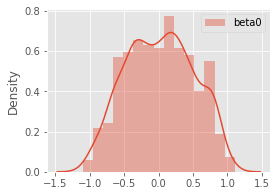

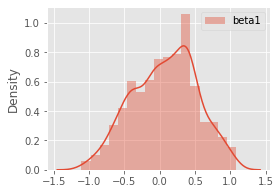

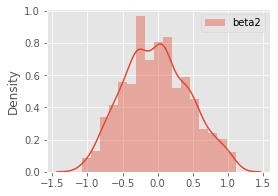

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


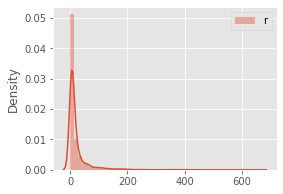

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


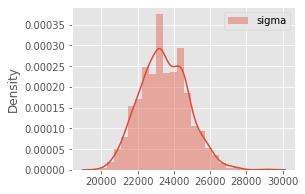

In [99]:
nodes = ["beta", "r", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(3):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

## Get predicted values

In [100]:
y_pred_btc = hmc_samples["y_pred_btc"].mean(axis=0)
print(y_pred_btc)
print(y_obs_btc[T:])

[ 1936.2169   1227.8193   1283.4734   -209.29314    41.24073   232.78947
  -865.74194  -408.28186 -1488.2844   2006.8606  -1006.3377   1005.30206
   129.74675  -104.32839 -1150.9766   1796.4131 ]
[39437.460938 38794.972656 38904.011719 37849.664063 39666.753906
 39338.785156 41143.929688 40951.378906 41801.15625  42190.652344
 41247.824219 41077.996094 42358.808594 42892.957031 43960.933594
 44395.964844]


## Plot predictions and true values

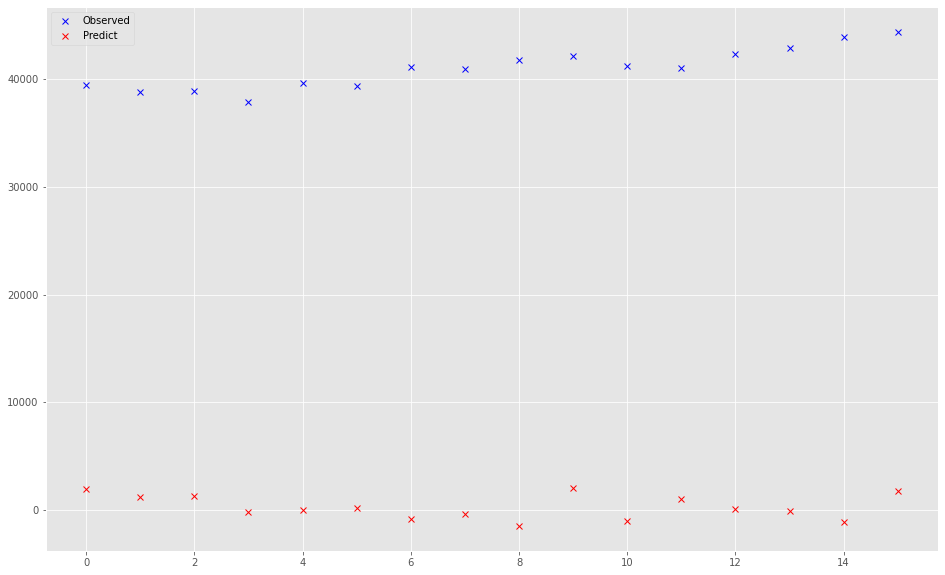

In [101]:
plt.plot(y_obs_btc[T:], "bx")
plt.plot(y_pred_btc,"rx")
plt.legend(["Observed", "Predict"])
plt.show()